In [67]:
from src.db.db_utils import db_utils
from src.db.controller import init_async_db
from src.config import ETHER_protocols
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [68]:

transactions, blocks, future = await init_async_db(False)
db_utils.set_tables(transactions, blocks, future)

transaction_table = db_utils.get_transactions()

protocol = ETHER_protocols.get('RoninBridge').lower()
transactions_rows = await transaction_table.get_all_rows_by_criteria({'contract': protocol})
print(len(transactions_rows))


2346


In [69]:
print(protocol)

0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2


In [70]:

df = pd.DataFrame([t.__dict__ for t in transactions_rows])

In [71]:
df.head()

,_sa_instance_state,contract,id,tx,gas_price,block,timestamp,gas,priority_fee
0,<sqlalchemy.orm.state.InstanceState object at ...,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,15607,0xef487a8e3480568fedd25446efd91adf39707dfbabb3...,22476838932,14440847,1648015210,215887,1500000000
1,<sqlalchemy.orm.state.InstanceState object at ...,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,16322,0xe8f951c1bd4e2ed1525de51e3e98c9c0c36f013c2634...,24664468524,14440885,1648015718,284939,1500000000
2,<sqlalchemy.orm.state.InstanceState object at ...,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,16328,0xa20c458d92ac0b656e3099900fb1fc6dfdf030a260ed...,24664468524,14440885,1648015718,284939,1500000000
3,<sqlalchemy.orm.state.InstanceState object at ...,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,16566,0x49264c938245b3733c9df240811b0fb3b475f36837c3...,17572318499,14440901,1648015904,259918,1500000000
4,<sqlalchemy.orm.state.InstanceState object at ...,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,16802,0x1b1dc1b538485797da9663e641e683d962227fb662d1...,22572020792,14440916,1648016125,215887,1363280649


In [72]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [73]:
df = df.set_index('timestamp').resample('30Min').max().reset_index()

/tmp/ipykernel_3211666/2237449792.py:1: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.



In [74]:
df.head()

,timestamp,contract,id,tx,gas_price,block,gas,priority_fee
0,2022-03-23 06:00:00,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,17862.0,0xef487a8e3480568fedd25446efd91adf39707dfbabb3...,2.555476e+10,14440973.0,284939.0,1.500000e+09
1,2022-03-23 06:30:00,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,19854.0,0xd417ed64a378f4da0df8ba56ab0f18da7b98aad24db7...,3.324477e+10,14441096.0,290813.0,1.500000e+09
2,2022-03-23 07:00:00,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,21831.0,0xfd7921ded583545216b0ceeedd72a7d7cae7c8be5f35...,2.495704e+10,14441215.0,293117.0,2.064659e+09
3,2022-03-23 07:30:00,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,24047.0,0xfababc0bd3abc069d4456129bd93095b76a3fc239897...,2.828676e+10,14441342.0,284817.0,2.000000e+09
4,2022-03-23 08:00:00,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,25936.0,0xda7e8681fab448b17b32739ef15dd867760c05baa936...,2.536580e+10,14441462.0,312822.0,2.000000e+09


In [75]:
df.shape

(173, 8)

In [76]:
df = df[(df['timestamp'] < '2022-04-10')]

In [77]:
fig = px.line(df.reset_index(), x='timestamp', y='priority_fee', title='NYC Taxi Demand')
#slider
fig.update_xaxes(
    # rangeslider_visible = True,
    # rangeselector = dict(
    #     buttons = list([
    #           dict(count=1, label='1y', step="year", stepmode="backward"),
    #           dict(count=2, label='2y', step="year", stepmode="backward"),
    #           dict(count=2, label='5y', step="year", stepmode="backward")
    #     ])
    # )
)
fig.show()

In [78]:
from prophet import Prophet
taxi_df = df.reset_index()[['timestamp', 'priority_fee']].rename({'timestamp':'ds', 'priority_fee':'y'}, axis='columns')

In [79]:
train = taxi_df
# train = taxi_df[(taxi_df['ds'] < '2022-04-10')]

In [80]:
# train['cap'] = 9 * 10**13
# train['floor'] = 0

m = Prophet()#growth='logistic')
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/home/vvlovsky/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [81]:
future = m.make_future_dataframe(periods=24*2, freq='30Min')
# future['cap'] = 10**13
# future['floor'] = 0

In [82]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

/home/vvlovsky/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/vvlovsky/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
216,2022-03-27 18:00:00,-8.240956e+08,-1.049030e+10,8.514890e+09
217,2022-03-27 18:30:00,-2.724043e+08,-9.880325e+09,8.296323e+09
218,2022-03-27 19:00:00,2.268032e+08,-9.170193e+09,9.645503e+09
219,2022-03-27 19:30:00,5.137886e+08,-8.825875e+09,9.153067e+09
220,2022-03-27 20:00:00,4.967230e+08,-8.036083e+09,9.586538e+09


In [83]:
forecast.shape

(221, 16)

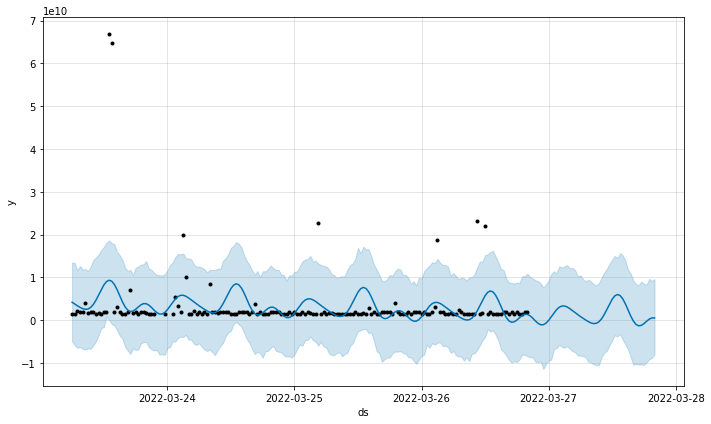

In [84]:
result = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

In [85]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [86]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

In [90]:
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')
# fig.add_scatter(result, x='ds', y='yhat', color='green', title='real')
fig.update_xaxes(
    # rangeslider_visible = True,
    rangeselector = dict(
        # buttons = list([
        #       dict(count=1, label='1y', step="year", stepmode="backward"),
        #       dict(count=2, label='3y', step="year", stepmode="backward"),
        #       dict(count=2, label='5y', step="year", stepmode="backward"),
        #       dict(step="all")
        # ])
    )
)
fig.show()

In [88]:
# for index, row in forecast.iterrows():
#     print({'contract': protocol, 'timestamp': row['ds'].timestamp(), 'priority_fee': row['yhat'],
#                             'priority_fee_lower': row['yhat_lower'], 'priority_fee_upper': row['yhat_upper']})